## 第六章 文本模块

本部分主要介绍Python中的文本处理模块：Gensim的使用，并介绍中文分词工具 Jieba。

Gensim 是一个免费的文本处理库， 它可以用来从文档中自动提取语义主题。Gensim致力于处理原始的、非结构化的普通文本。Gensim中包含许多先进常用的文本处理算法，如Word2Vec,潜在语义分析（Latent Semantic Analysis，LSA）、隐含狄利克雷分配（Latent Dirichlet Allocation，LDA）等。 Gensim 是一个无监督的学习包，这意味着用户只需准备文本，其他什么信息都用提供。
    
Gensim工具包主要运行对象是英文的文本，中文文本和英文文本最大的不同是中文需要分词。Jieba是一个功能很强大的分词工具包。本讲将通过有趣的例子讲解如何使用这些工具包。


## 第一节  Gensim 模块简介

**安装：**

pip install --upgrade gensim

or

conda install -c conda-forge gensim

**Gensim 的基本特性**

- Memory independence – there is no need for the whole training corpus to reside fully in RAM at any one time (can process large, web-scale corpora).
- Memory sharing – trained models can be persisted to disk and loaded back via mmap. Multiple processes can share the same data, cutting down RAM footprint.
- Efficient implementations for several popular vector space algorithms, including Word2Vec, Doc2Vec, FastText, TF-IDF, Latent Semantic Analysis (LSI, LSA, see LsiModel), Latent Dirichlet Allocation (LDA, see LdaModel) or Random Projection (see RpModel).
- I/O wrappers and readers from several popular data formats.
- Fast similarity queries for documents in their semantic representation.



**The principal design objectives behind Gensim are:**
- Straightforward interfaces and low API learning curve for developers. Good for prototyping.
- Memory independence with respect to the size of the input corpus; all intermediate steps and algorithms operate in a streaming fashion, accessing one document at a time.


**一些基本概念**

**Corpus**

一些数字文档的集合（A collection of digital documents）。

Gensim 中的Corpora有两个主要功能：

- 作为输入，训练模型。模型使用这些corpora训练参数。
- 整理和管理文档。训练好模型后，模型行可以用来对新的文档抽取信息：如提取topic等。这些新的文档就组成新的coupus。

**Vector space model**

 在向量空间中，所有的文档都用向量来表示。这些向量代表一些特征的取值。特征可以看作是一个问题的代表，取值可以看成是该问题的答案。例如：
 
        How many times does the word splonge appear in the document? Zero.
        
        How many paragraphs does the document consist of? Two.
        
        How many fonts does the document use? Five.

问题通常用id来表示，比如上面三个问题，可以分别用1，2，3来表示。于是，文档就可以用（id，value）数对来表示：(1, 0.0), (2, 2.0), (3, 5.0).


如果事先把所有的问题都排列好，就可以用一个向量来表示文档，如上面的例子可以用(0.0, 2.0, 5.0)来表示。

通常，一个corpus用很多问题来描述，但是一个文档中的问题很少。所以，要用非常稀疏的向量来表示一个文档，即向量中有很多0。可以使用稀疏矩阵表示方法。

如果两个文档对应的向量很接近，通常代表两个文档有“某种”近似性，可以对文档进行聚类和分类。当然，聚类或者分类的效果如何，取决于特征的选取是否有针对性。


**Gensim sparse vector, Bag-of-words vector**

    在Gensim中，用稀疏向量老表示文档，以节约空间。例如上面的例子可以用向量(0.0, 2.0, 5.0)表示,也可以用[(2, 2.0), (3, 5.0)] 来表示，注意到这种表示方法去掉了(1, 0.0)。这种表示方法对于稀疏向量特别有效。


**Gensim streamed corpus**

    Gensim 并不事先指定corpus的格式。 A corpus 就是**稀疏向量**的序列。

    例如 [ [(2, 2.0), (3, 5.0)], [(3, 1.0)] ] 是一个含有两个文档的corpus。这是用python list 来表示的。实际上Gensim可以用任何课循环的结构来表示corpus。可以是numpy array，可以是data frame。 只要他能得到一个bag of wrods vector即可。
   

**Model, Transformation**

    稀疏向量用来表示文档。多个文档可以用更抽象的参数来表达。所以model本质上是从文本数据到另一种数据（参数）的变换。模型的参数是从训练数据训练出来的。
    
    Gensim 实现了许多有用的文本处理model，包括 Word2Vec, LsiModel, LdaModel, FastText 等。


## Corpora and Vector Spaces

从文本到向量空间

In [38]:
documents = ["Human machine interface for lab abc computer applications",
              "A survey of user opinion of computer system response time",
              "The EPS user interface management system",
              "System and human system engineering testing of EPS",
              "Relation of user perceived response time to error measurement",
              "The generation of random binary unordered trees",
              "The intersection graph of paths in trees",
              "Graph minors IV Widths of trees and well quasi ordering",
              "Graph minors A survey"]

In [39]:
len(documents)

9

第一步：切分词 （tokenize），去stopwords

In [40]:
stoplist = set('for a of the and to in'.split())

In [41]:
texts = [
     [word for word in document.lower().split() if word not in stoplist]
     for document in documents
 ]

In [42]:
texts

[['human', 'machine', 'interface', 'lab', 'abc', 'computer', 'applications'],
 ['survey', 'user', 'opinion', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'management', 'system'],
 ['system', 'human', 'system', 'engineering', 'testing', 'eps'],
 ['relation', 'user', 'perceived', 'response', 'time', 'error', 'measurement'],
 ['generation', 'random', 'binary', 'unordered', 'trees'],
 ['intersection', 'graph', 'paths', 'trees'],
 ['graph', 'minors', 'iv', 'widths', 'trees', 'well', 'quasi', 'ordering'],
 ['graph', 'minors', 'survey']]

第二步：对每个词语分别计数

In [43]:
from collections import defaultdict
frequency = defaultdict(int)

In [44]:
frequency['a']

0

In [45]:
for text in texts:
    for token in text:
        frequency[token] += 1

In [46]:
len(frequency)

36

In [47]:
frequency

defaultdict(int,
            {'a': 0,
             'human': 2,
             'machine': 1,
             'interface': 2,
             'lab': 1,
             'abc': 1,
             'computer': 2,
             'applications': 1,
             'survey': 2,
             'user': 3,
             'opinion': 1,
             'system': 4,
             'response': 2,
             'time': 2,
             'eps': 2,
             'management': 1,
             'engineering': 1,
             'testing': 1,
             'relation': 1,
             'perceived': 1,
             'error': 1,
             'measurement': 1,
             'generation': 1,
             'random': 1,
             'binary': 1,
             'unordered': 1,
             'trees': 3,
             'intersection': 1,
             'graph': 3,
             'paths': 1,
             'minors': 2,
             'iv': 1,
             'widths': 1,
             'well': 1,
             'quasi': 1,
             'ordering': 1})

第三步：去掉出现次数特别低的词语

In [48]:
texts = [
     [token for token in text if frequency[token] > 1]
     for text in texts
 ]

In [49]:
texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [50]:
print(texts)

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]


In [51]:
from pprint import pprint
pprint(texts)

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]


为将corpus转化成一个向量表示：矩阵。需要构建一个从questions（or words）到id的映射：词典。

In [52]:
from gensim import corpora
dictionary = corpora.Dictionary(texts)
#dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference


In [53]:
print(dictionary)


Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)


In [54]:
print(dictionary.token2id) ## 给每个单词（token）一个编号（id）

{'computer': 0, 'human': 1, 'interface': 2, 'response': 3, 'survey': 4, 'system': 5, 'time': 6, 'user': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


如果我们有一个（新的）文档，使用刚才定义好的词典，可以将之转化为一个向量。

两步：
1. 切分词 
2. 转化（遇到新词忽略）

In [55]:
new_doc = "Human computer interaction"
new_vec = dictionary.doc2bow(new_doc.lower().split())


In [56]:
print(new_vec)  # the word "interaction" does not appear in the dictionary and is ignored

[(0, 1), (1, 1)]


函数（方法）doc2bow()（doc to bag of words）就是用来数一数每个不同单词出现的次数，把单词对应到对应的id，然后返回一个稀疏向量。稀疏向量[(0, 1), (1, 1)] 意味着： 在新的文档“Human computer interaction”中，单词computer (id 0) 和 human (id 1) 出现1次，字典中其他的10个单词出现0次。

若将一个corpus 转化成一个稀疏矩阵，只需将corpus里每一个文档单独转成稀疏向量即可。

In [57]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [58]:
corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

当文本比较大的时候，我们不希望将文本一次性都读进内存，而是一次处理一个文档。这时候，用到一种数据结构：**生成器**。下面简单介绍一下生成器。

生成器非常类似list。不同的是list一次创建所有元素，把所有的空间给开辟出来。而生成器只是告诉元算将按照什么规律放进内存中，不用的时候就不开辟空间。边计算边生成。

**生成器的创建**


In [60]:
g = (x*x for x in range(10))

In [61]:
g

<generator object <genexpr> at 0x1a19bb98b8>

In [66]:
print(g)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [62]:
g[0]

TypeError: 'generator' object is not subscriptable

In [63]:
g = [x*x for x in range(10)]

In [64]:
g

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [65]:
g[0]

0

对生成器的引用，常用的有两种方法，而第二种方法最常用。注意：generator是一个**可迭代对象**。

In [71]:
g = (x*x for x in range(10))

In [72]:
next(g),next(g),next(g)

(0, 1, 4)

In [73]:
for ele in g:
    print(ele)

9
16
25
36
49
64
81


使用函数来定义generator

In [79]:
def even():
    print('step 1')
    yield 2
    print('step 2')
    yield(4)
    print('step 3')
    yield(6)

In [80]:
ev = even()

In [81]:
next(ev)

step 1


2

In [82]:
for e in ev:
    print(e)

step 2
4
step 3
6


In [83]:
def fib(max):
    n, a, b = 0, 0, 1
    while n < max:
        yield b
        a, b = b, a + b
        n = n + 1

In [94]:
fibs = fib(8)

In [85]:
for f in fibs:
    print(f)

1
1
2
3
5
8
13
21


In [95]:
list(fibs)

[1, 1, 2, 3, 5, 8, 13, 21]

In [98]:
list(fibs)

[]

回到 corpus 的生成

In [86]:
class MyCorpus(object):
     def __iter__(self):
         for line in open('mycorpus.txt'):
             # assume there's one document per line, tokens separated by whitespace
             yield dictionary.doc2bow(line.lower().split())

In [89]:
corpus_memory_friendly = MyCorpus()  # doesn't load the corpus into memory!
print(corpus_memory_friendly)

In [96]:
for vector in corpus_memory_friendly:  # load one vector into memory at a time
     print(vector)

[(0, 1), (1, 1), (2, 1)]
[(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
[(2, 1), (5, 1), (7, 1), (8, 1)]
[(1, 1), (5, 2), (8, 1)]
[(3, 1), (6, 1), (7, 1)]
[(9, 1)]
[(9, 1), (10, 1)]
[(9, 1), (10, 1), (11, 1)]
[(4, 1), (10, 1), (11, 1)]


In [97]:
pprint(list(corpus_memory_friendly))  # calling list() will convert any sequence to a plain Python list

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]


## Topics and Transformations

这里我们将介绍将文本表达从一种方式（BOW）转换为另一种方式（tf-idf，topics， etc）。

转换过程有两个目标：
1. 带来文本的隐结构，挖掘单词之间的关系，期望带来语意理解。
2. 使文档表达更加紧凑。


变换的基本步骤
1. 模型初始化
2. 使用模型来转化文档

In [103]:
from gensim import models

In [109]:
tfidf = models.TfidfModel(corpus) ## 初始化，tfidf模型“不需要”training！

In [110]:
doc_bow = [(0, 1), (1, 1)]

In [111]:
tfidf[doc_bow]

[(0, 0.7071067811865476), (1, 0.7071067811865476)]

In [135]:
corpus_tfidf = tfidf[corpus]

In [113]:
corpus_tfidf

In [114]:
for doc in corpus_tfidf:
     print(doc)

[(0, 0.5773502691896257), (1, 0.5773502691896257), (2, 0.5773502691896257)]
[(0, 0.44424552527467476), (3, 0.44424552527467476), (4, 0.44424552527467476), (5, 0.3244870206138555), (6, 0.44424552527467476), (7, 0.3244870206138555)]
[(2, 0.5710059809418182), (5, 0.4170757362022777), (7, 0.4170757362022777), (8, 0.5710059809418182)]
[(1, 0.49182558987264147), (5, 0.7184811607083769), (8, 0.49182558987264147)]
[(3, 0.6282580468670046), (6, 0.6282580468670046), (7, 0.45889394536615247)]
[(9, 1.0)]
[(9, 0.7071067811865475), (10, 0.7071067811865475)]
[(9, 0.5080429008916749), (10, 0.5080429008916749), (11, 0.695546419520037)]
[(4, 0.6282580468670046), (10, 0.45889394536615247), (11, 0.6282580468670046)]


$weight_{i,j} = frequency_{i,j} * \log_2 \frac{D}{document\_freq_{i}}$

$weight_{i,j} = wlocal(frequency_{i,j}) * wglobal(document\_freq_{i}, D)$

常用的transformations(model)
- tfidf
- lsi
- lda

In [133]:
model = models.TfidfModel(corpus, normalize=True) ## tfidf

In [136]:
model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=300) ## lsi

In [137]:
model = models.LdaModel(corpus, id2word=dictionary, num_topics=100) ## LDA

一个例子

In [139]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)# initialize an LSI transformation

In [140]:
corpus_lsi = lsi[corpus_tfidf]  # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [141]:
lsi.print_topics(2)

[(0,
  '0.703*"trees" + 0.538*"graph" + 0.402*"minors" + 0.187*"survey" + 0.061*"system" + 0.060*"time" + 0.060*"response" + 0.058*"user" + 0.049*"computer" + 0.035*"interface"'),
 (1,
  '0.460*"system" + 0.373*"user" + 0.332*"eps" + 0.328*"interface" + 0.320*"time" + 0.320*"response" + 0.293*"computer" + 0.280*"human" + 0.171*"survey" + -0.161*"trees"')]

In [142]:
for doc in corpus_lsi:  # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
     print(doc)


[(0, 0.06600783396090251), (1, 0.5200703306361852)]
[(0, 0.19667592859142344), (1, 0.7609563167700055)]
[(0, 0.08992639972446315), (1, 0.7241860626752507)]
[(0, 0.07585847652178036), (1, 0.632055158600343)]
[(0, 0.10150299184980016), (1, 0.5737308483002961)]
[(0, 0.7032108939378312), (1, -0.16115180214025707)]
[(0, 0.8774787673119833), (1, -0.16758906864659295)]
[(0, 0.9098624686818578), (1, -0.14086553628718898)]
[(0, 0.6165825350569278), (1, 0.05392907566389456)]


In [144]:
[(0, -0.066), (1, 0.520)] # "Human machine interface for lab abc computer applications"
[(0, -0.197), (1, 0.761)] # "A survey of user opinion of computer system response time"
[(0, -0.090), (1, 0.724)] # "The EPS user interface management system"
[(0, -0.076), (1, 0.632)] # "System and human system engineering testing of EPS"
[(0, -0.102), (1, 0.574)] # "Relation of user perceived response time to error measurement"
[(0, -0.703), (1, -0.161)] # "The generation of random binary unordered trees"
[(0, -0.877), (1, -0.168)] # "The intersection graph of paths in trees"
[(0, -0.910), (1, -0.141)] # "Graph minors IV Widths of trees and well quasi ordering"
[(0, -0.617), (1, 0.054)] # "Graph minors A survey"

[(0, -0.617), (1, 0.054)]

## Similarity Queries

Goal:similarity between pairs of documents, or the similarity between a specific document and a set of other documents (such as a user query vs. indexed documents).

In [145]:
from gensim import models
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)

In [147]:
doc = "Human computer interaction"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]  # convert the query to LSI space
print(vec_lsi)


[(0, 0.4618210045327159), (1, -0.0700276652789995)]


In [151]:
from gensim import similarities
index = similarities.MatrixSimilarity(lsi[corpus])  # transform corpus to LSI space and index it

In [165]:
sims = index[vec_lsi]  # perform a similarity query against the corpus
pprint(list(enumerate(sims))) 

[(0, 0.998093),
 (1, 0.93748635),
 (2, 0.9984453),
 (3, 0.9865886),
 (4, 0.90755945),
 (5, -0.12416792),
 (6, -0.10639259),
 (7, -0.09879464),
 (8, 0.050041765)]


In [166]:
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims)  # print sorted (document number, similarity score) 2-tuples

[(2, 0.9984453), (0, 0.998093), (3, 0.9865886), (1, 0.93748635), (4, 0.90755945), (8, 0.050041765), (7, -0.09879464), (6, -0.10639259), (5, -0.12416792)]


In [167]:
[(2, 0.99844527), # The EPS user interface management system
(0, 0.99809301), # Human machine interface for lab abc computer applications
(3, 0.9865886), # System and human system engineering testing of EPS
(1, 0.93748635), # A survey of user opinion of computer system response time
(4, 0.90755945), # Relation of user perceived response time to error measurement
(8, 0.050041795), # Graph minors A survey
(7, -0.098794639), # Graph minors IV Widths of trees and well quasi ordering
(6, -0.1063926), # The intersection graph of paths in trees
(5, -0.12416792)] # The generation of random binary unordered trees

[(2, 0.99844527),
 (0, 0.99809301),
 (3, 0.9865886),
 (1, 0.93748635),
 (4, 0.90755945),
 (8, 0.050041795),
 (7, -0.098794639),
 (6, -0.1063926),
 (5, -0.12416792)]

The thing to note here is that documents no. 2 ("The EPS user interface management system") and 4 ("Relation of user perceived response time to error measurement") would never be returned by a standard boolean fulltext search, because they do not share any common words with "Human computer interaction". However, after applying LSI, we can observe that both of them received quite high similarity scores (no. 2 is actually the most similar!), which corresponds better to our intuition of them sharing a “computer-human” related topic with the query. In fact, this semantic generalization is the reason why we apply transformations and do topic modelling in the first place.

**Topic Model**

In [191]:
# extract 2 LDA topics, using 1 pass and updating once every 1 chunk (10,000 documents)
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, update_every=1, passes=1)


In [192]:
lda.print_topics(2)

[(0,
  '0.150*"graph" + 0.150*"trees" + 0.117*"minors" + 0.089*"interface" + 0.083*"human" + 0.074*"survey" + 0.071*"computer" + 0.064*"system" + 0.060*"user" + 0.057*"eps"'),
 (1,
  '0.170*"system" + 0.129*"user" + 0.102*"time" + 0.095*"response" + 0.087*"eps" + 0.075*"computer" + 0.072*"survey" + 0.065*"human" + 0.060*"interface" + 0.054*"trees"')]

In [193]:
lda.get_document_topics(corpus[0])

[(0, 0.7810477), (1, 0.2189523)]

In [196]:
doc_bow = corpus[0]
doc_lda = lda[doc_bow]

In [195]:
doc_lda

[(0, 0.78101426), (1, 0.21898568)]

用类似LSI的方式来retrive相似docs

In [254]:
index = similarities.MatrixSimilarity(lda[corpus])  # transform corpus to lda space and index it

In [255]:
doc = "Human computer interaction"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lda = lda[vec_bow] 

In [256]:
vec_lda

[(0, 0.6087217), (1, 0.3912784)]

In [260]:
sims = index[vec_lda] 

In [261]:
sims

array([0.95598096, 0.6181355 , 0.66656095, 0.65768224, 0.6668091 ,
       0.9775667 , 0.93866295, 0.91477025, 0.9233764 ], dtype=float32)

In [263]:
list(enumerate(sims)) # print (document_number, document_similarity) 2-tuples

[(0, 0.95598096),
 (1, 0.6181355),
 (2, 0.66656095),
 (3, 0.65768224),
 (4, 0.6668091),
 (5, 0.9775667),
 (6, 0.93866295),
 (7, 0.91477025),
 (8, 0.9233764)]

In [258]:
sims = sorted(enumerate(sims), key=lambda item: -item[1])

In [259]:
sims

[(5, 0.9775667),
 (0, 0.95598096),
 (6, 0.93866295),
 (8, 0.9233764),
 (7, 0.91477025),
 (4, 0.6668091),
 (2, 0.66656095),
 (3, 0.65768224),
 (1, 0.6181355)]

**word2vec**

In [201]:
from gensim.models import Word2Vec
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
model = Word2Vec(sentences, min_count=1)

In [209]:
from gensim.models import Word2Vec
model = Word2Vec(texts, min_count=1,size=2)

In [210]:
texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [218]:
[model.wv.similarity("graph", u"trees"),model.wv.similarity("graph", u"computer"),
model.wv.similarity("computer", u"trees")]

[-0.25412136, -0.48533088, 0.96896124]

In [212]:
model.wv['computer']

array([ 0.21329825, -0.1021911 ], dtype=float32)

In [213]:
model.wv['computer'].shape

(2,)

In [229]:
[model.wv[wd] for wd in dictionary.id2token.values()]

[array([ 0.21329825, -0.1021911 ], dtype=float32),
 array([ 0.0875387 , -0.03911031], dtype=float32),
 array([0.10965599, 0.17801744], dtype=float32),
 array([0.22472006, 0.21634078], dtype=float32),
 array([-0.16486742, -0.02523296], dtype=float32),
 array([ 0.22886619, -0.00961605], dtype=float32),
 array([-0.00428852, -0.04174777], dtype=float32),
 array([-0.0066641 , -0.03673173], dtype=float32),
 array([0.21474117, 0.1743777 ], dtype=float32),
 array([ 0.14349584, -0.12003089], dtype=float32),
 array([-0.1628166 , -0.11556574], dtype=float32),
 array([-0.19727072,  0.03786341], dtype=float32)]

In [231]:
import pandas as pd
df = pd.DataFrame([model.wv[wd] for wd in dictionary.id2token.values()])

In [232]:
df

,0,1
0,0.213298,-0.102191
1,0.087539,-0.039110
2,0.109656,0.178017
3,0.224720,0.216341
4,-0.164867,-0.025233
5,0.228866,-0.009616
6,-0.004289,-0.041748
7,-0.006664,-0.036732
8,0.214741,0.174378
9,0.143496,-0.120031


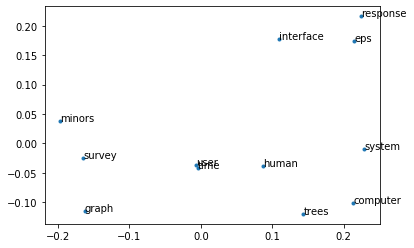

In [245]:
words = [wd for wd in dictionary.id2token.values()]
import matplotlib.pyplot as plt
plt.plot(df.iloc[:,0],df.iloc[:,1],'.')
for i in range(df.shape[0]):
    x = df.iloc[i,0]
    y = df.iloc[i,1]
    text = words[i]
    plt.text(x,y,text,fontsize=10)

In [240]:
words = [wd for wd in dictionary.id2token.values()]

In [241]:
words

['computer',
 'human',
 'interface',
 'response',
 'survey',
 'system',
 'time',
 'user',
 'eps',
 'trees',
 'graph',
 'minors']

More information:https://radimrehurek.com/gensim/tutorial.html

## 第三节  Jieba 模块简介

Jieba 是一款很好用的中文分词包

**特点：**

    支持三种分词模式：
        精确模式，试图将句子最精确地切开，适合文本分析；
        全模式，把句子中所有的可以成词的词语都扫描出来, 速度非常快，但是不能解决歧义；
        搜索引擎模式，在精确模式的基础上，对长词再次切分，提高召回率，适合用于搜索引擎分词。

    支持繁体分词

    支持自定义词典

In [172]:
# encoding=utf-8
import jieba

seg_list = jieba.cut("我来到北京大学光华管理学院。", cut_all=True)
print("Full Mode: " + "/ ".join(seg_list))  # 全模式



Full Mode: 我/ 来到/ 北京/ 北京大学/ 北京大学光华管理学院/ 大学/ 光华/ 管理/ 管理学/ 理学/ 理学院/ 学院/ / 


In [174]:
seg_list = jieba.cut("我来到北京大学光华管理学院", cut_all=False)
print("Default Mode: " + "/ ".join(seg_list))  # 精确模式



Default Mode: 我/ 来到/ 北京大学光华管理学院


In [175]:
seg_list = jieba.cut("他来到了网易杭研大厦")  # 默认是精确模式
print(", ".join(seg_list))



他, 来到, 了, 网易, 杭研, 大厦


In [176]:
seg_list = jieba.cut_for_search("小明硕士毕业于中国科学院计算所，后在日本京都大学深造")  # 搜索引擎模式
print(", ".join(seg_list))

小明, 硕士, 毕业, 于, 中国, 科学, 学院, 科学院, 中国科学院, 计算, 计算所, ，, 后, 在, 日本, 京都, 大学, 日本京都大学, 深造


**调整词典**

- 使用 add_word(word, freq=None, tag=None) 和 del_word(word) 可在程序中动态修改词典。
- 使用 suggest_freq(segment, tune=True) 可调节单个词语的词频，使其能（或不能）被分出来。
- 注意：自动计算的词频在使用 HMM 新词发现功能时可能无效。


In [177]:
print('/'.join(jieba.cut('如果放到post中将出错。', HMM=False)))

如果/放到/post/中将/出错/。


In [178]:
jieba.suggest_freq(('中', '将'), True)

494

In [179]:
print('/'.join(jieba.cut('如果放到post中将出错。', HMM=False)))

如果/放到/post/中/将/出错/。


In [180]:
print('/'.join(jieba.cut('「台中」正确应该不会被切开', HMM=False)))

「/台/中/」/正确/应该/不会/被/切开


In [181]:
jieba.suggest_freq('台中', True)

69

In [182]:
test_sent = (
"李小福是创新办主任也是云计算方面的专家; 什么是八一双鹿\n"
"例如我输入一个带“韩玉赏鉴”的标题，在自定义词库中也增加了此词为N类\n"
"「台中」正確應該不會被切開。mac上可分出「石墨烯」；此時又可以分出來凱特琳了。"
)

In [183]:
words = jieba.cut(test_sent)
print('/'.join(words))

李小福/是/创新/办/主任/也/是/云/计算/方面/的/专家/;/ /什么/是/八/一双/鹿/
/例如/我/输入/一个/带/“/韩玉/赏鉴/”/的/标题/，/在/自定义词/库中/也/增加/了/此/词为/N/类/
/「/台中/」/正確/應該/不會/被/切開/。/mac/上/可/分出/「/石墨/烯/」/；/此時/又/可以/分出/來凱/特琳/了/。


In [184]:
jieba.add_word('石墨烯')
jieba.add_word('凱特琳')
jieba.del_word('自定义词')

In [185]:
words = jieba.cut(test_sent)
print('/'.join(words))

李小福/是/创新/办/主任/也/是/云/计算/方面/的/专家/;/ /什么/是/八/一双/鹿/
/例如/我/输入/一个/带/“/韩玉/赏鉴/”/的/标题/，/在/自定义/词库/中/也/增加/了/此/词为/N/类/
/「/台中/」/正確/應該/不會/被/切開/。/mac/上/可/分出/「/石墨烯/」/；/此時/又/可以/分出/來/凱特琳/了/。


In [249]:
", ".join(jieba.cut("北京大学光华管理学院中商业分析是你值得信赖的选择"))

'北京大学光华管理学院, 中, 商业, 分析, 是, 你, 值得, 信赖, 的, 选择'

In [250]:
jieba.add_word('商业分析')


In [251]:
", ".join(jieba.cut("北京大学光华管理学院中商业分析是你值得信赖的选择"))

'北京大学光华管理学院, 中, 商业分析, 是, 你, 值得, 信赖, 的, 选择'

**作业**

1. 对红楼梦分词
2. 研究前80回和后80回虚词分布的异同
3. 利用word2vec模型，研究贾宝玉和各人物之间的远近
4. 将各人物图画在二维平面坐标中
5. 利用topic model，研究前5回的主题